#### Import

In [16]:
import os
import sys
import numpy as np
from cellpose import models
from cellpose.plot import image_to_rgb, mask_overlay
from cellpose.utils import masks_to_outlines
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage import measure
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

In [2]:
sys.path.append('..')

In [ ]:
from src.utils.image_utils import load_czi_images


#### Function

In [4]:
# Quick version - simple 360 degree rotation
def quick_rotation_gif(masks,max_labels=15, z_scale=3.0, cell_slice_th=5, filename='quick_rotation.gif'):
    """Simple 360 degree rotation GIF"""
    
    # Plot setup
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get and plot cells (simplified)
    unique_labels = np.unique(masks)[1:max_labels]  # First 5 cells only
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
    def animate(frame):
        ax.clear()
        angle = frame * 10  # 10 degrees per frame
        
        for i, label in enumerate(unique_labels):
            cell_mask = (masks == label).astype(np.uint8)
            if np.sum(cell_mask) < cell_slice_th:
                continue
            try:
                # Apply smoothing to make more spherical
                cell_mask_smooth = ndimage.binary_fill_holes(cell_mask)
                cell_mask_smooth = ndimage.gaussian_filter(cell_mask_smooth.astype(float), sigma=1.0)
            
                # Use adjusted spacing to compress Z-axis
                verts, faces, normals, values = measure.marching_cubes(
                                cell_mask_smooth, 
                                level=0.5, 
                                spacing=(1, 1, 1/z_scale))
                # Plot the surface
                ax.plot_trisurf(verts[:, 2], verts[:, 1], verts[:, 0], 
                          triangles=faces, alpha=0.7, 
                          color=colors[i], label=f'Cell {label}')
            except:
                pass
        
        ax.set_title(f'Rotating 3D Cells (angle: {angle}°)')
        ax.view_init(elev=30, azim=angle)
        ax.set_xlim(0, masks.shape[2])
        ax.set_ylim(0, masks.shape[1])
        ax.set_zlim(0, masks.shape[0])
        ax.set_zlabel('Z')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    anim = animation.FuncAnimation(fig, animate, frames=36, interval=200)  # 36 frames = 360°
    anim.save(filename, writer=PillowWriter(fps=5))
    print(f"Quick rotation saved as {filename}")
    plt.close()

In [ ]:
def create_gif_from_arrays(arrays, output_path='animation.gif', fps=5, cmap='gray', titles=None):
    """
    Create a GIF from a series of 2D or 3D arrays
    
    Parameters:
    - arrays: list of numpy arrays or single 3D array where first dimension is frames
    - output_path: path to save the GIF
    - fps: frames per second
    - cmap: colormap for visualization
    - titles: optional list of titles for each frame
    """
    # Handle input format
    if isinstance(arrays, np.ndarray):
        if arrays.ndim == 3:
            frame_arrays = [arrays[i] for i in range(arrays.shape[0])]
        else:
            frame_arrays = [arrays]
    else:
        frame_arrays = arrays
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Initialize with first frame
    im = ax.imshow(frame_arrays[0], cmap=cmap, animated=True)
    ax.axis('off')
    
    def animate(frame):
        im.set_array(frame_arrays[frame])
        if titles:
            ax.set_title(titles[frame])
        else:
            ax.set_title(f'Frame {frame + 1}/{len(frame_arrays)}')
        return [im]
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=len(frame_arrays), 
                                 interval=1000//fps, blit=True, repeat=True)
    
    # Save as GIF
    anim.save(output_path, writer=PillowWriter(fps=fps))
    print(f"GIF saved to {output_path}")
    plt.close()

In [20]:
def enhance_cell_image_contrast(image):
    if image.shape[0] < 4:
        image = np.transpose(image, (1, 2, 0))
    if image.shape[-1] < 3 or image.ndim < 3:
        image = image_to_rgb(image, channels=[0, 0])
    else:
        if image.max() <= 50.0:
            image = np.uint8(np.clip(image, 0, 1) * 255)
    return image

#### Input

In [5]:
czi_file_path = '/home/dafei/data/MS2/gRNA2_12.03.25-st-13-II---.czi'
output_dir = '/home/dafei/output/MS2/3d_cell_segmentation'

In [6]:
os.makedirs(output_dir, exist_ok=True)

In [7]:
image_data = load_czi_images(czi_file_path)

Successfully loaded /home/dafei/data/MS2/gRNA2_12.03.25-st-13-II---.czi
data shape: (1, 80, 2, 9, 1024, 1024, 1)


In [ ]:
# get Z stack at time t
t = 0
z_stack_t = image_data[0, t, 1, :, :, :, 0]

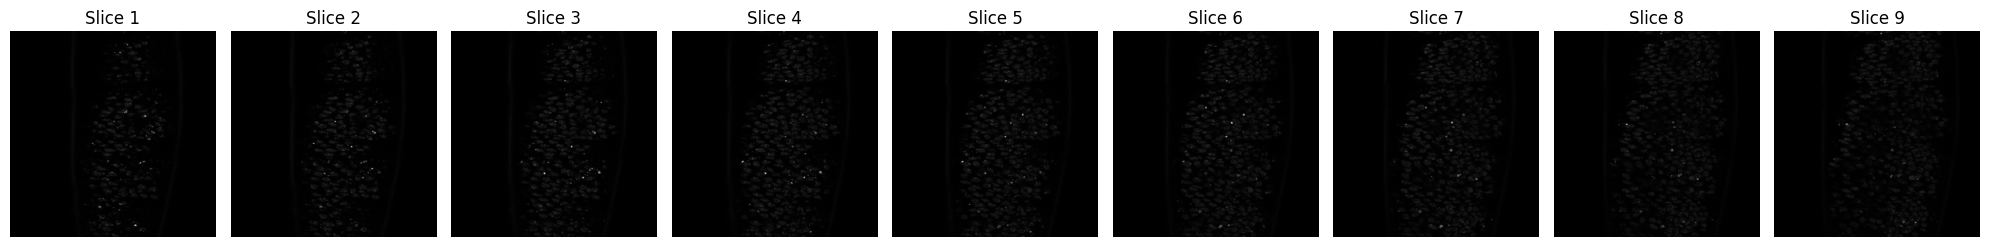

In [ ]:
fig, ax = plt.subplots(1, z_stack_t.shape[0], figsize=(20, 10))
for i in range(z_stack_t.shape[0]):
    ax[i].imshow(z_stack_t[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Slice {i+1}')
plt.tight_layout()
plt.show()

In [11]:
model = models.CellposeModel(gpu=True)

In [12]:
masks, flows, _ = model.eval(z_stack_t0, z_axis=0, channel_axis=1,
                                batch_size=1,
                                do_3D=True, flow3D_smooth=1)

In [13]:
save_dir = os.path.join(output_dir, os.path.basename(czi_file_path).replace('.czi', ''))
os.makedirs(save_dir, exist_ok=True)

In [14]:
save_path = os.path.join(save_dir, 'z_stack_t0_seg_masks.npy')
np.save(save_path, masks)
print(f"Segmentation results saved to {save_path}")

Segmentation results saved to /home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/z_stack_t0_seg_masks.npy


In [35]:
label =  np.random.randint(1, np.max(masks))
frames = []
for i in range(masks.shape[0]):
    img = z_stack_t0[i]
    img = enhance_cell_image_contrast(img)
    maski = masks[i]
    cell_mask = (maski==1).astype(np.uint8)
    overlay = mask_overlay(img, cell_mask)
    frames.append(overlay)
    

In [36]:
create_gif_from_arrays(frames, output_path=os.path.join(save_dir, 'cell_rotation2.gif'),fps=1,
                      titles=[f'Cell {label} - Slice {i+1}' for i in range(len(frames))],
                      cmap='gray')

GIF saved to /home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/cell_rotation2.gif
